# Credit Card User Segmentation
## Code Challenge, Jessica Peck, October 18, 2018

You work as a data scientist at a credit card company. A senior VP is leading an effort to reduce costs associated with signup incentives by offering credit cards with carefully targeted benefits that will attract new cardholders. As a first step, she would like you to examine cardholder data collected over the last 6 months in order to understand the various kinds of users who use the company’s products. She is especially interested in getting an idea of which benefits to associate with each new card offering.

In [144]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
import time

from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
import statsmodels.api as sm

import missingno as msno

%pylab inline

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('max_colwidth',500)    

Populating the interactive namespace from numpy and matplotlib


/Users/Jess/anaconda3/envs/insight/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['axes', 'f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
# Read in CSV data

data = pd.read_csv('../cc_info.csv')

In [233]:
data.head(2)

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,nopurchase,nocashadvance,purchaseandcash,balance_ish
0,C10001,40.900749,0.818182,95.4,0.0,95.4,0.000000,0.166667,0.0,0.083333,0.00,0,2,1000.0,201.802084,139.509787,0.000000,12,False,True,False,-106.402084
1,C10002,3202.467416,0.909091,0.0,0.0,0.0,6442.945483,0.000000,0.0,0.000000,0.25,4,0,7000.0,4103.032597,1072.340217,0.222222,12,True,False,False,2339.912886


In [232]:
data.tail(2)

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,nopurchase,nocashadvance,purchaseandcash,balance_ish
8948,C19189,13.457564,0.833333,0.00,0.00,0.0,36.558778,0.000000,0.000000,0.0,0.166667,2,0,500.0,52.549959,55.755628,0.25,6,True,False,False,-15.991181
8949,C19190,372.708075,0.666667,1093.25,1093.25,0.0,127.040008,0.666667,0.666667,0.0,0.333333,2,23,1200.0,63.165404,88.288956,0.00,6,False,False,True,1157.124604


In [5]:
# How many Rows? Variables?

print(len(data), len(data.columns))

8950 18


In [6]:
# summary stats by variable

data.describe()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
count,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8949.000000,8950.000000,8637.000000,8950.000000,8950.000000
mean,1564.474828,0.877271,1003.204834,592.437371,411.067645,978.871112,0.490351,0.202458,0.364437,0.135144,3.248827,14.709832,4494.449450,1733.143852,864.206542,0.153715,11.517318
std,2081.531879,0.236904,2136.634782,1659.887917,904.338115,2097.163877,0.401371,0.298336,0.397448,0.200121,6.824647,24.857649,3638.815725,2895.063757,2372.446607,0.292499,1.338331
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,0.000000,0.019163,0.000000,6.000000
25%,128.281915,0.888889,39.635000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,1.000000,1600.000000,383.276166,169.123707,0.000000,12.000000
50%,873.385231,1.000000,361.280000,38.000000,89.000000,0.000000,0.500000,0.083333,0.166667,0.000000,0.000000,7.000000,3000.000000,856.901546,312.343947,0.000000,12.000000
75%,2054.140036,1.000000,1110.130000,577.405000,468.637500,1113.821139,0.916667,0.300000,0.750000,0.222222,4.000000,17.000000,6500.000000,1901.134317,825.485459,0.142857,12.000000
max,19043.138560,1.000000,49039.570000,40761.250000,22500.000000,47137.211760,1.000000,1.000000,1.000000,1.500000,123.000000,358.000000,30000.000000,50721.483360,76406.207520,1.000000,12.000000


In [7]:
# Do the data types of the 18 variables match what I assumed they should be?

for varname in data:
    print(type(data[varname][42]), varname)

<class 'str'> CUST_ID
<class 'numpy.float64'> BALANCE
<class 'numpy.float64'> BALANCE_FREQUENCY
<class 'numpy.float64'> PURCHASES
<class 'numpy.float64'> ONEOFF_PURCHASES
<class 'numpy.float64'> INSTALLMENTS_PURCHASES
<class 'numpy.float64'> CASH_ADVANCE
<class 'numpy.float64'> PURCHASES_FREQUENCY
<class 'numpy.float64'> ONEOFF_PURCHASES_FREQUENCY
<class 'numpy.float64'> PURCHASES_INSTALLMENTS_FREQUENCY
<class 'numpy.float64'> CASH_ADVANCE_FREQUENCY
<class 'numpy.int64'> CASH_ADVANCE_TRX
<class 'numpy.int64'> PURCHASES_TRX
<class 'numpy.float64'> CREDIT_LIMIT
<class 'numpy.float64'> PAYMENTS
<class 'numpy.float64'> MINIMUM_PAYMENTS
<class 'numpy.float64'> PRC_FULL_PAYMENT
<class 'numpy.int64'> TENURE


In [8]:
# Are there duplicate records (by customer id)?

print(len(data), len(data["CUST_ID"].unique()))

8950 8950


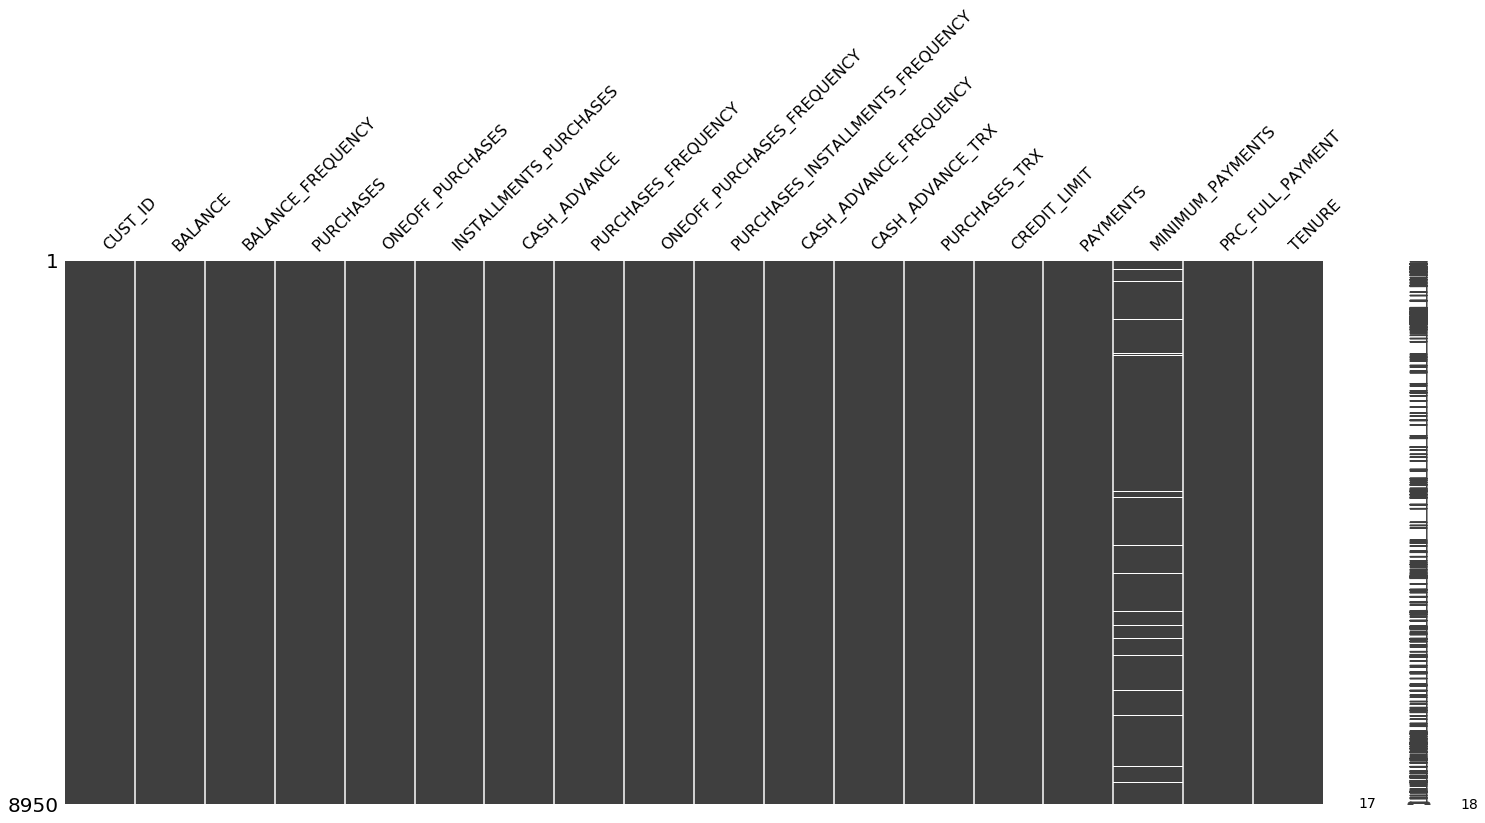

In [9]:
# Are there missing values? (Yes, quite a few in Min Payments, also one sneaky one in credit limit)

msno.matrix(data)

In [10]:
# missing value in credit limit

data[pd.isna(data['CREDIT_LIMIT'])]

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
5203,C15349,18.400472,0.166667,0.0,0.0,0.0,186.853063,0.0,0.0,0.0,0.166667,1,0,NaN,9.040017,14.418723,0.0,6


In [11]:
# Variable names

data.columns

Index(['CUST_ID', 'BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES',
       'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE',
       'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY',
       'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY',
       'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS',
       'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT', 'TENURE'],
      dtype='object')

In [12]:
# How many missing in Min Payments?

missingstuff = data[pd.isna(data['MINIMUM_PAYMENTS'])]
len(missingstuff)

In [14]:
missingstuff.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
3,C10004,1666.670542,0.636364,1499.0,1499.0,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.0,12
45,C10047,2242.311686,1.000000,437.0,97.0,340.0,184.648692,0.333333,0.083333,0.333333,0.166667,2,5,2400.0,0.000000,NaN,0.0,12
47,C10049,3910.111237,1.000000,0.0,0.0,0.0,1980.873201,0.000000,0.000000,0.000000,0.500000,7,0,4200.0,0.000000,NaN,0.0,12
54,C10056,6.660517,0.636364,310.0,0.0,310.0,0.000000,0.666667,0.000000,0.666667,0.000000,0,8,1000.0,417.016763,NaN,0.0,12
55,C10057,1311.995984,1.000000,1283.9,1283.9,0.0,0.000000,0.250000,0.250000,0.000000,0.000000,0,6,6000.0,0.000000,NaN,0.0,12


## Summary: EDA
There are 18 variables and 8950 rows.

The main variable with missing values is minimum payment. It is missing 313 values.
There is also one missing value in credit limit.

Most of the variables are skewed towards zero or are bimodal with peaks at the extremes of the distributions. For example: the min balance is 0 and the max balance is about $19,000. 

In [18]:
# distribution plots for all numeric variables

def make_plots(dataframe):

    f, axes = plt.subplots(9, 2, figsize=(18, 40), sharex=False)

    sns.distplot( dataframe["BALANCE"] , color="skyblue", ax=axes[0, 0])
    sns.distplot( dataframe["BALANCE_FREQUENCY"] , color="olive", ax=axes[0, 1])

    sns.distplot( dataframe["PURCHASES"] , color="gold", ax=axes[1, 0])
    sns.distplot( dataframe["ONEOFF_PURCHASES"] , color="teal", ax=axes[1, 1])

    sns.distplot( dataframe["INSTALLMENTS_PURCHASES"] , color="green", ax=axes[2, 0])
    sns.distplot( dataframe["CASH_ADVANCE"] , color="red", ax=axes[2, 1])

    sns.distplot( dataframe["PURCHASES_FREQUENCY"] , color="gray", ax=axes[3, 0])
    sns.distplot( dataframe["ONEOFF_PURCHASES_FREQUENCY"] , color="orange", ax=axes[3, 1])

    sns.distplot( dataframe["PURCHASES_INSTALLMENTS_FREQUENCY"] , color="yellow", ax=axes[4, 0])
    sns.distplot( dataframe["CASH_ADVANCE_FREQUENCY"] , color="purple", ax=axes[4, 1])

    sns.distplot( dataframe["CASH_ADVANCE_TRX"] , color="pink", ax=axes[5, 0])
    sns.distplot( dataframe["PURCHASES_TRX"] , color="blue", ax=axes[5, 1])

    sns.distplot( dataframe["CREDIT_LIMIT"][pd.notna(data["CREDIT_LIMIT"])] , color="cyan", ax=axes[6, 0])
    sns.distplot( dataframe["PAYMENTS"] , color="tan", ax=axes[6, 1])

    sns.distplot( dataframe["MINIMUM_PAYMENTS"][pd.notna(data["MINIMUM_PAYMENTS"])] , color="limegreen", ax=axes[7, 0])
    sns.distplot( dataframe["PRC_FULL_PAYMENT"] , color="brown", ax=axes[7, 1])

    sns.distplot( dataframe["TENURE"] , color="violet", ax=axes[8, 0])


/Users/Jess/anaconda3/envs/insight/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


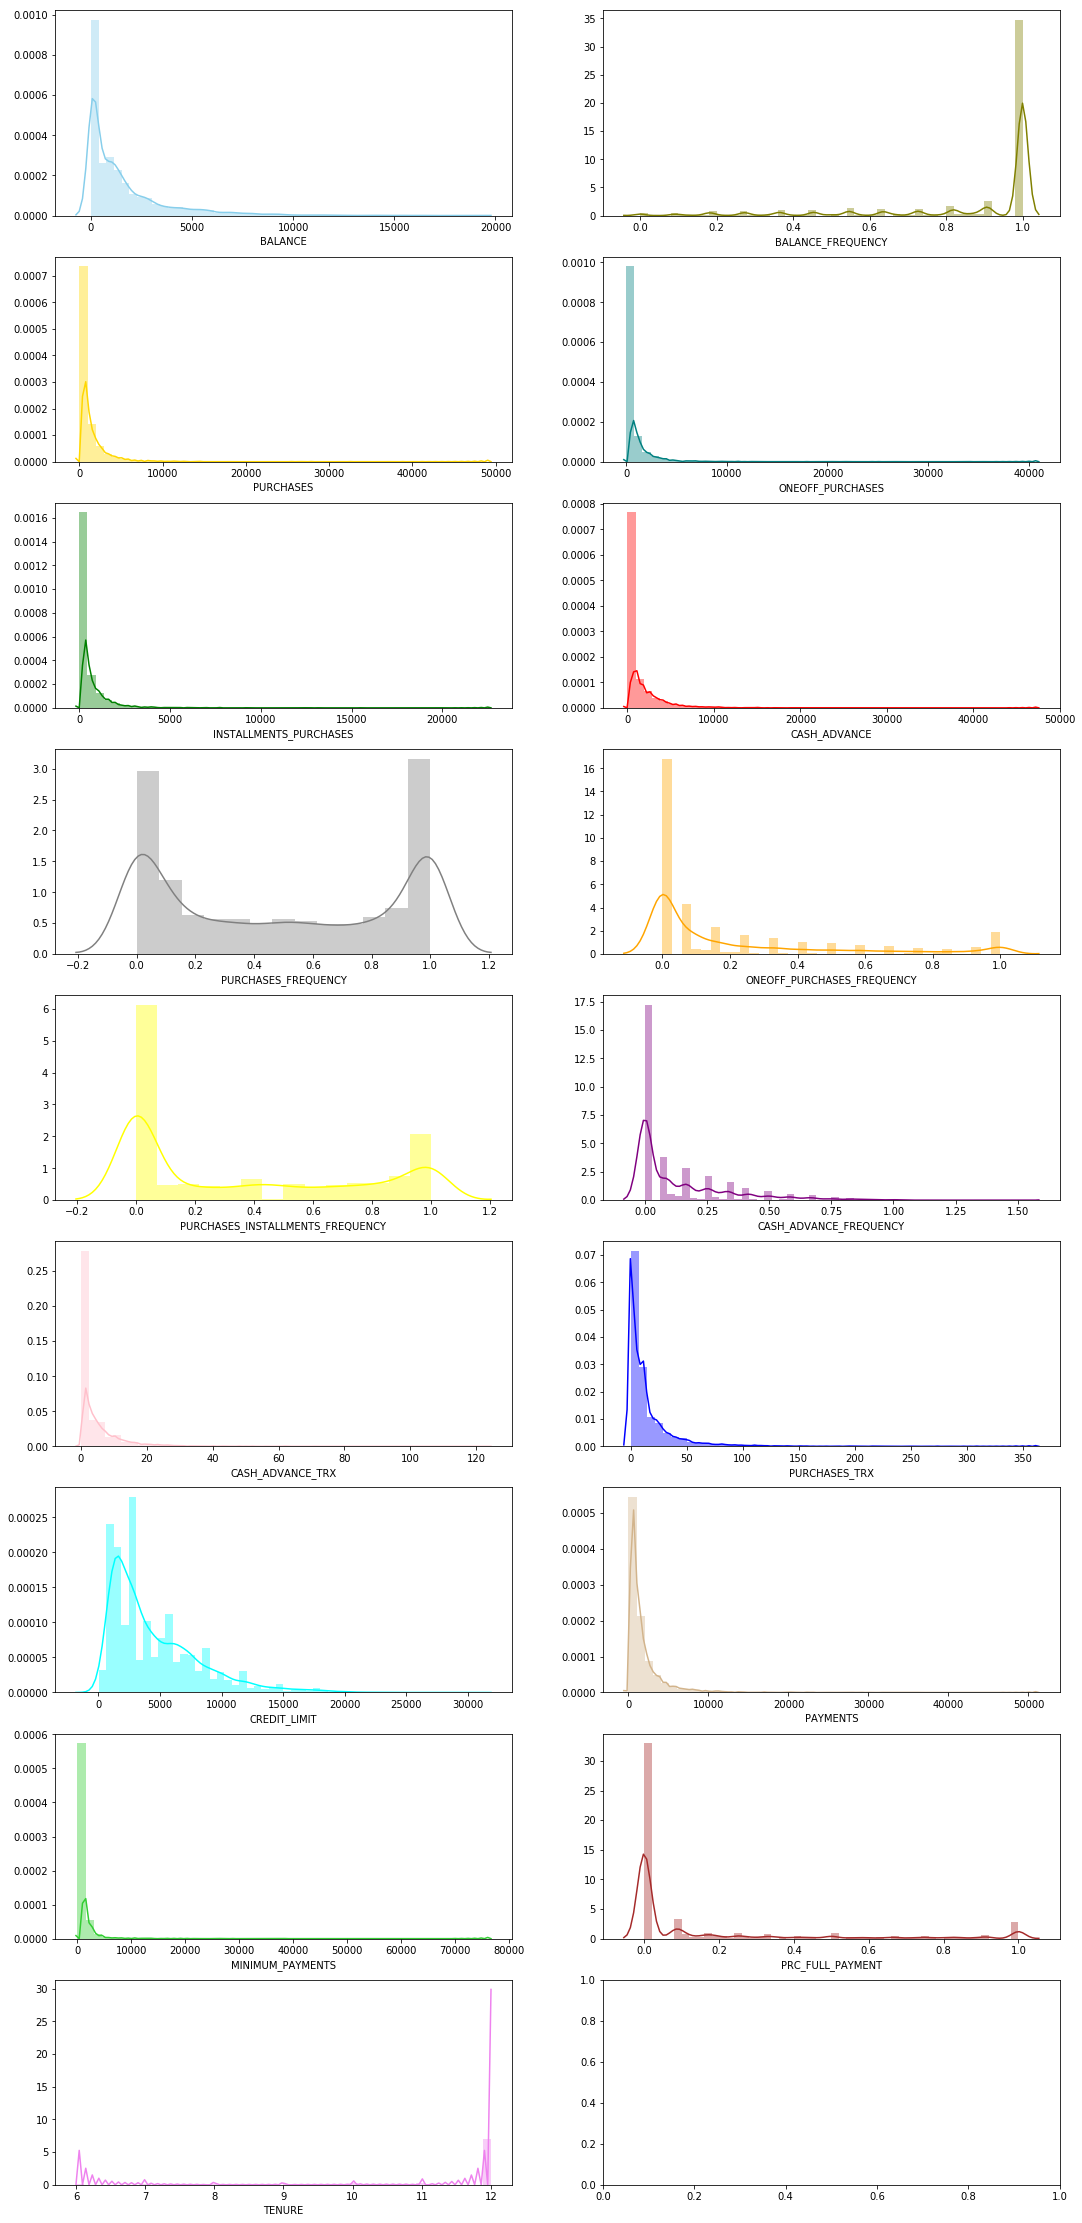

In [19]:
make_plots(data)

/Users/Jess/anaconda3/envs/insight/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/Jess/anaconda3/envs/insight/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/Jess/anaconda3/envs/insight/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/Users/Jess/anaconda3/envs/insight/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return u

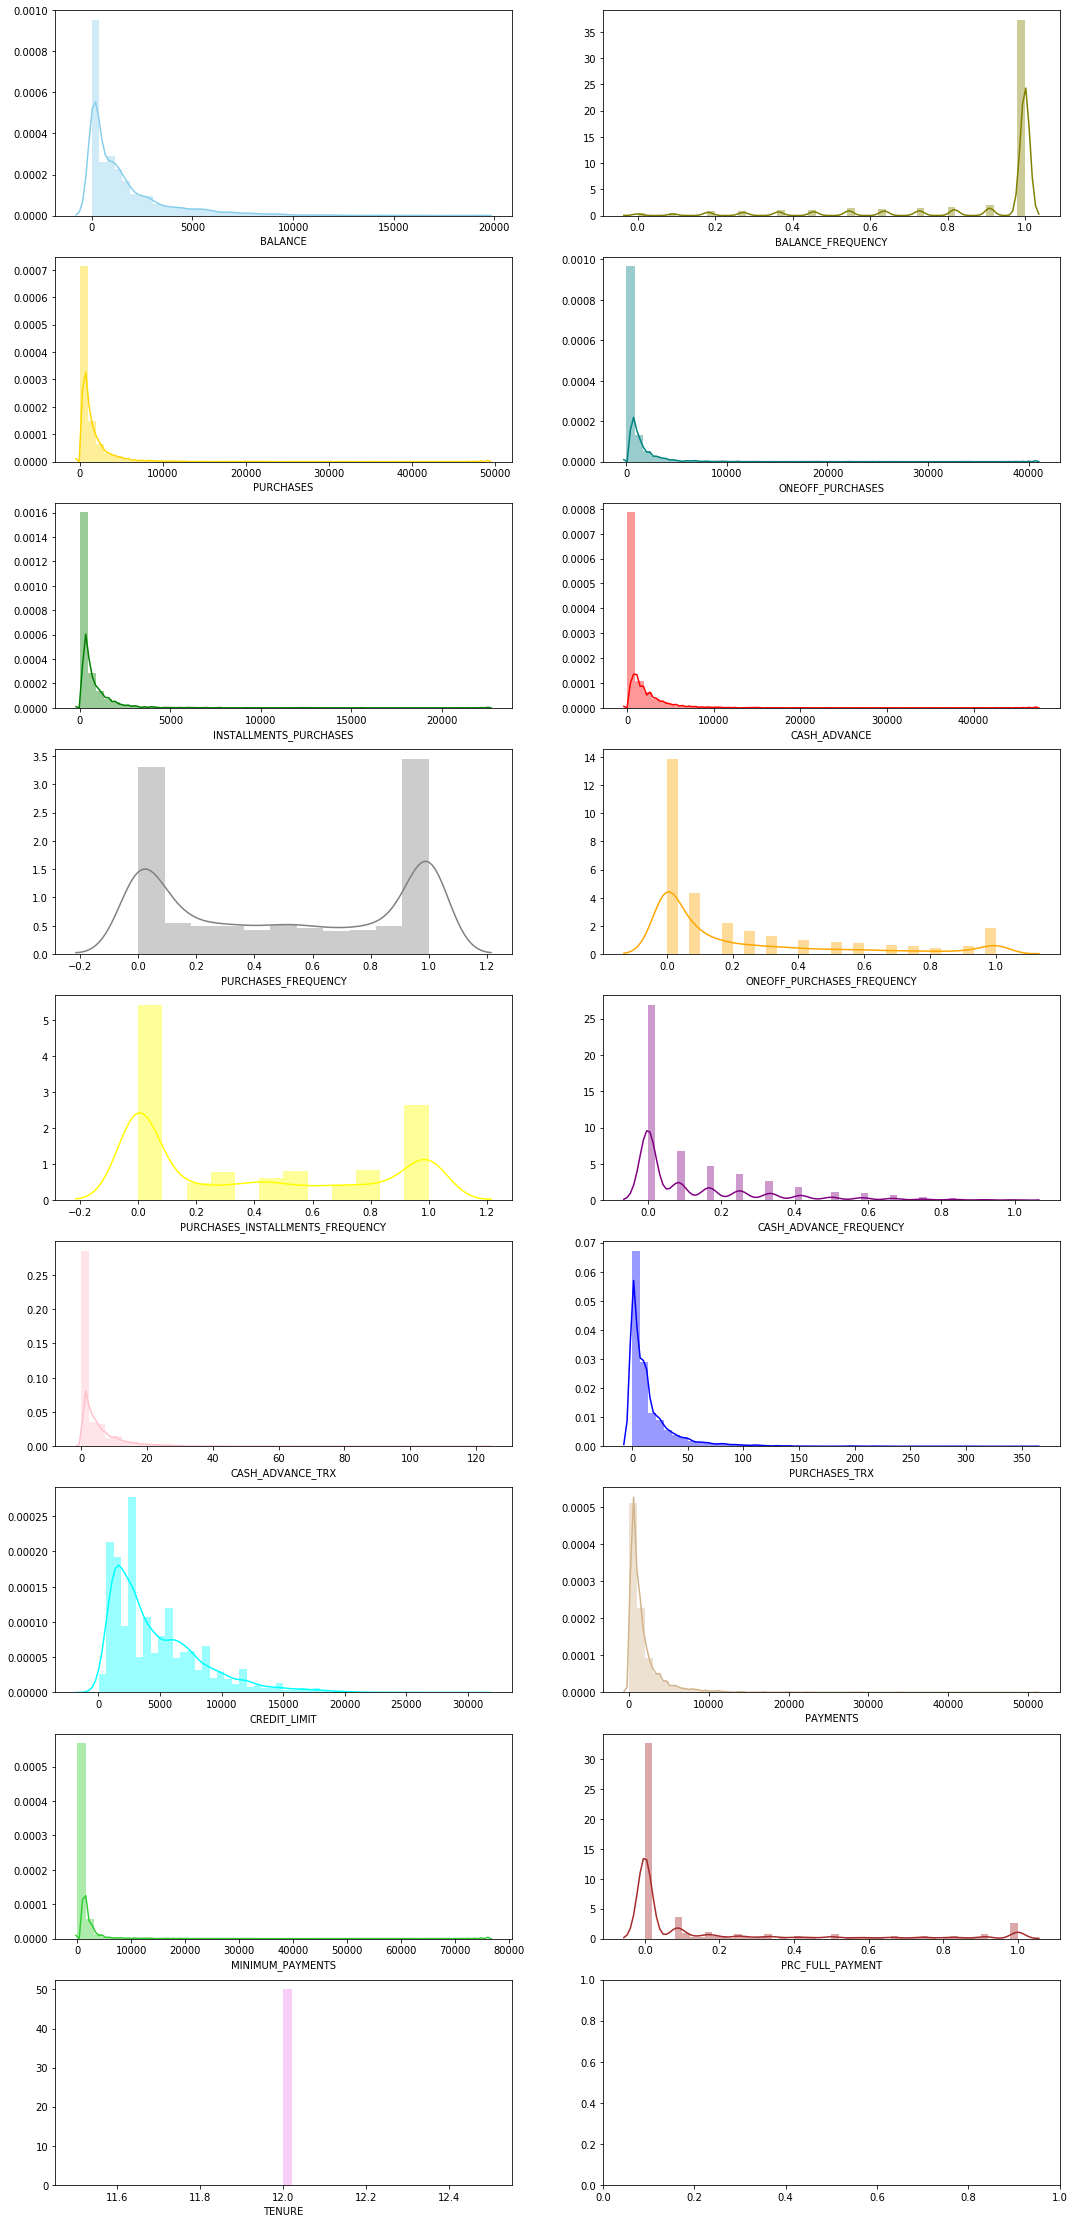

In [24]:
make_plots(data[data["TENURE"] == 12])

/Users/Jess/anaconda3/envs/insight/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/Jess/anaconda3/envs/insight/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/Jess/anaconda3/envs/insight/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/Users/Jess/anaconda3/envs/insight/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return u

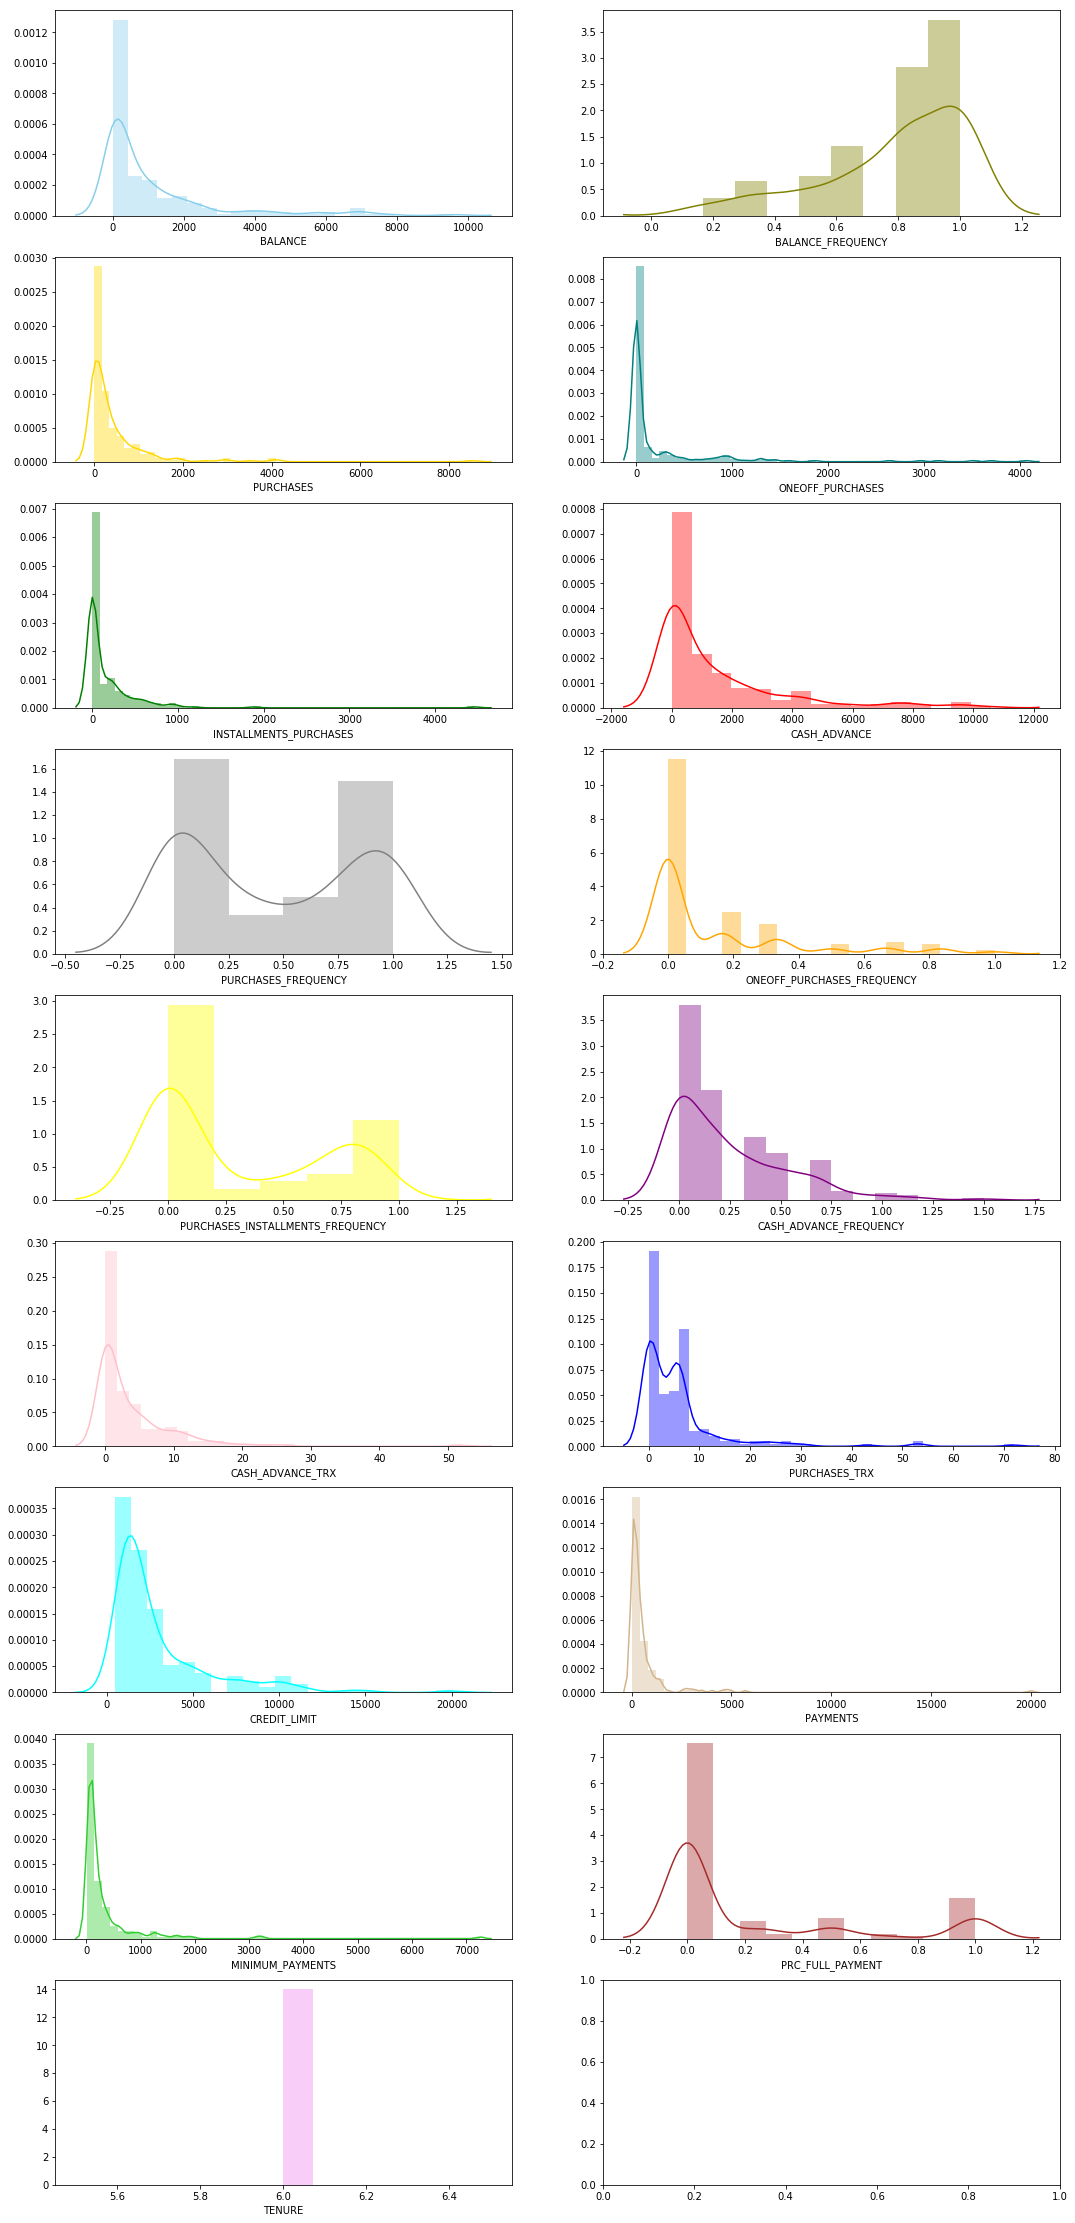

In [23]:
make_plots(data[data["TENURE"] == 6])

/Users/Jess/anaconda3/envs/insight/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/Jess/anaconda3/envs/insight/lib/python3.6/site-packages/numpy/lib/histograms.py:815: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/Users/Jess/anaconda3/envs/insight/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/Jess/anaconda3/envs/insight/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FA

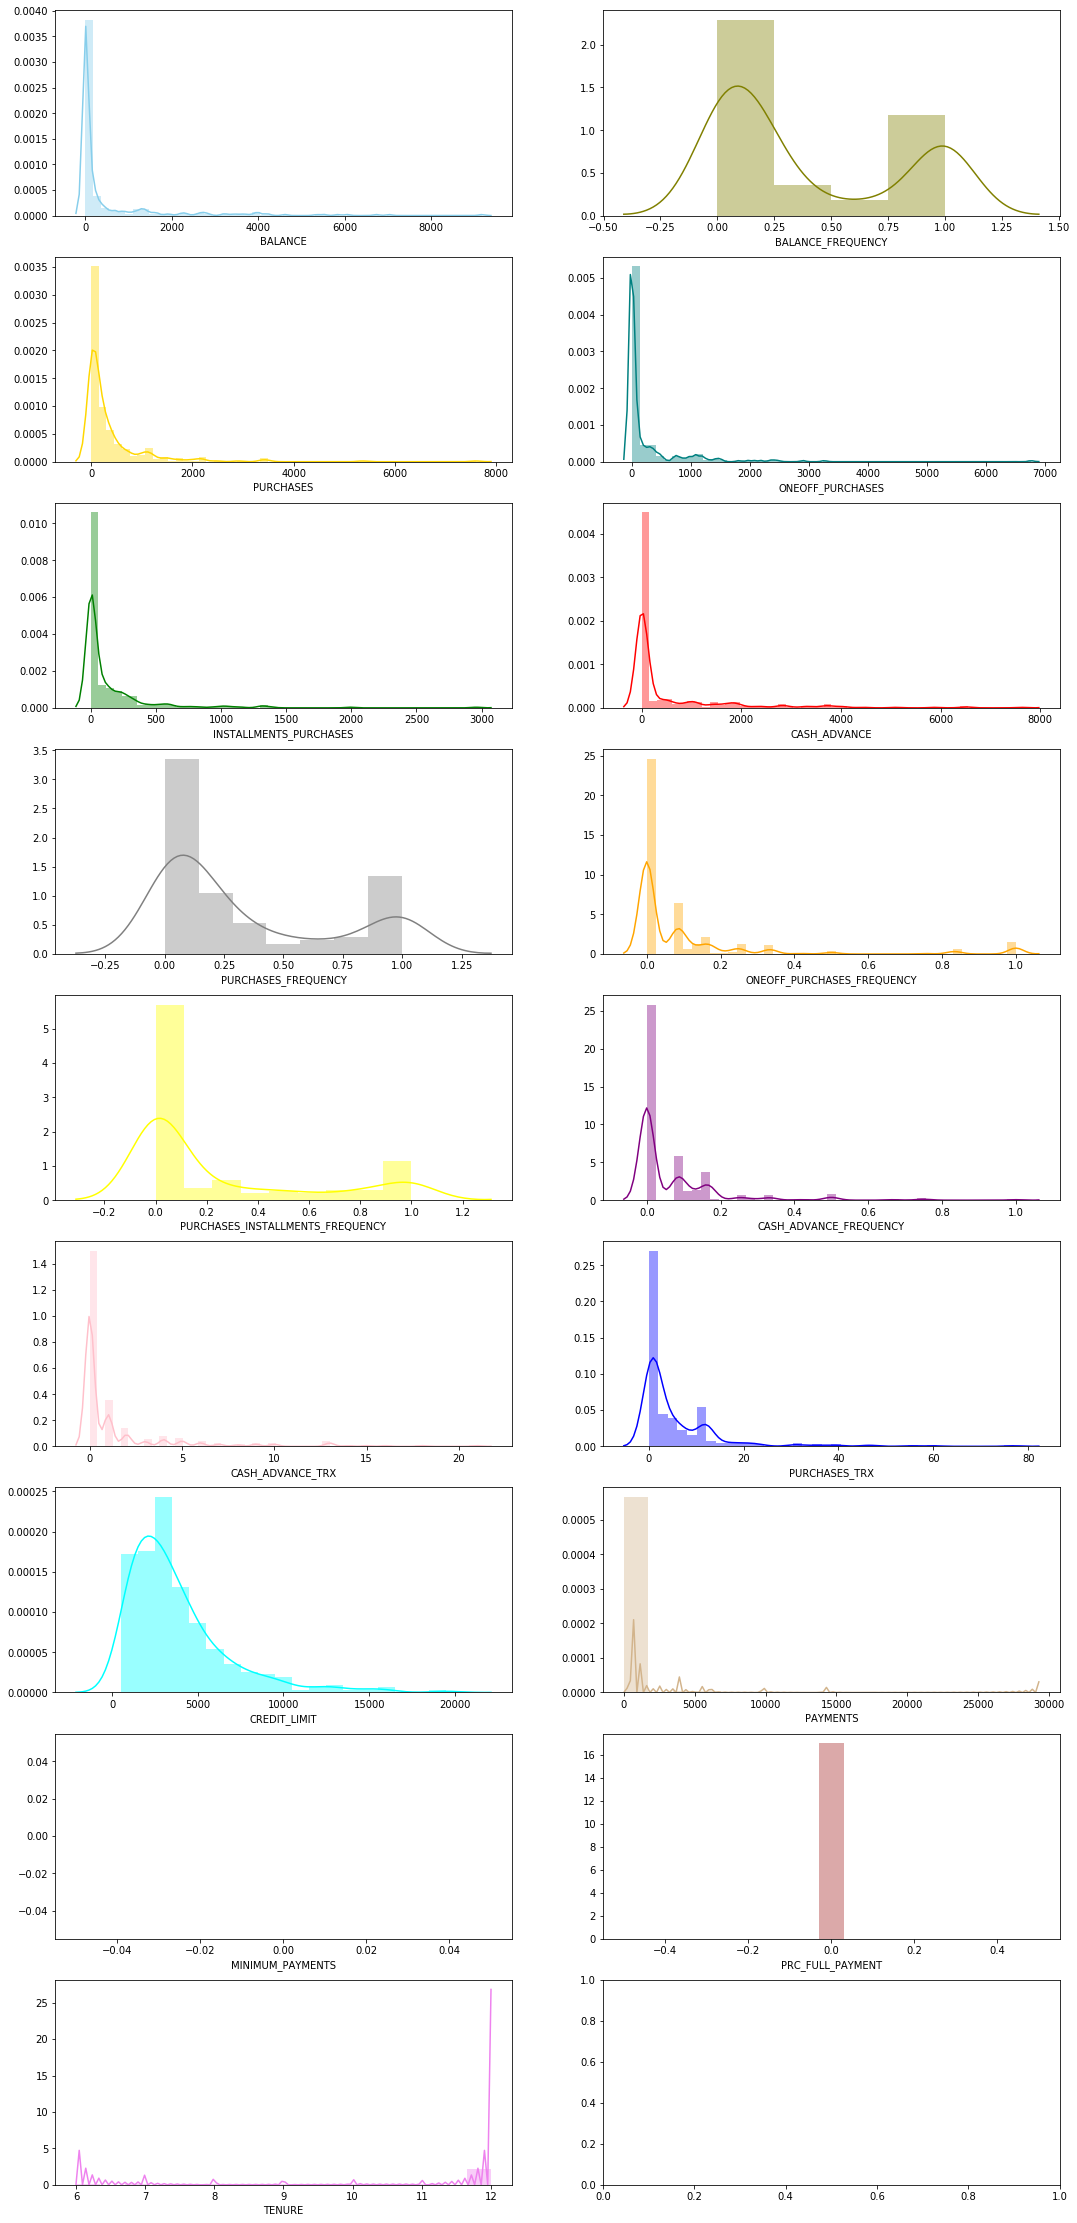

In [74]:
# are distributions fundamentally different for na rows in min payments or can I dropna?
make_plots( data[pd.isna(data["MINIMUM_PAYMENTS"])] )

/Users/Jess/anaconda3/envs/insight/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


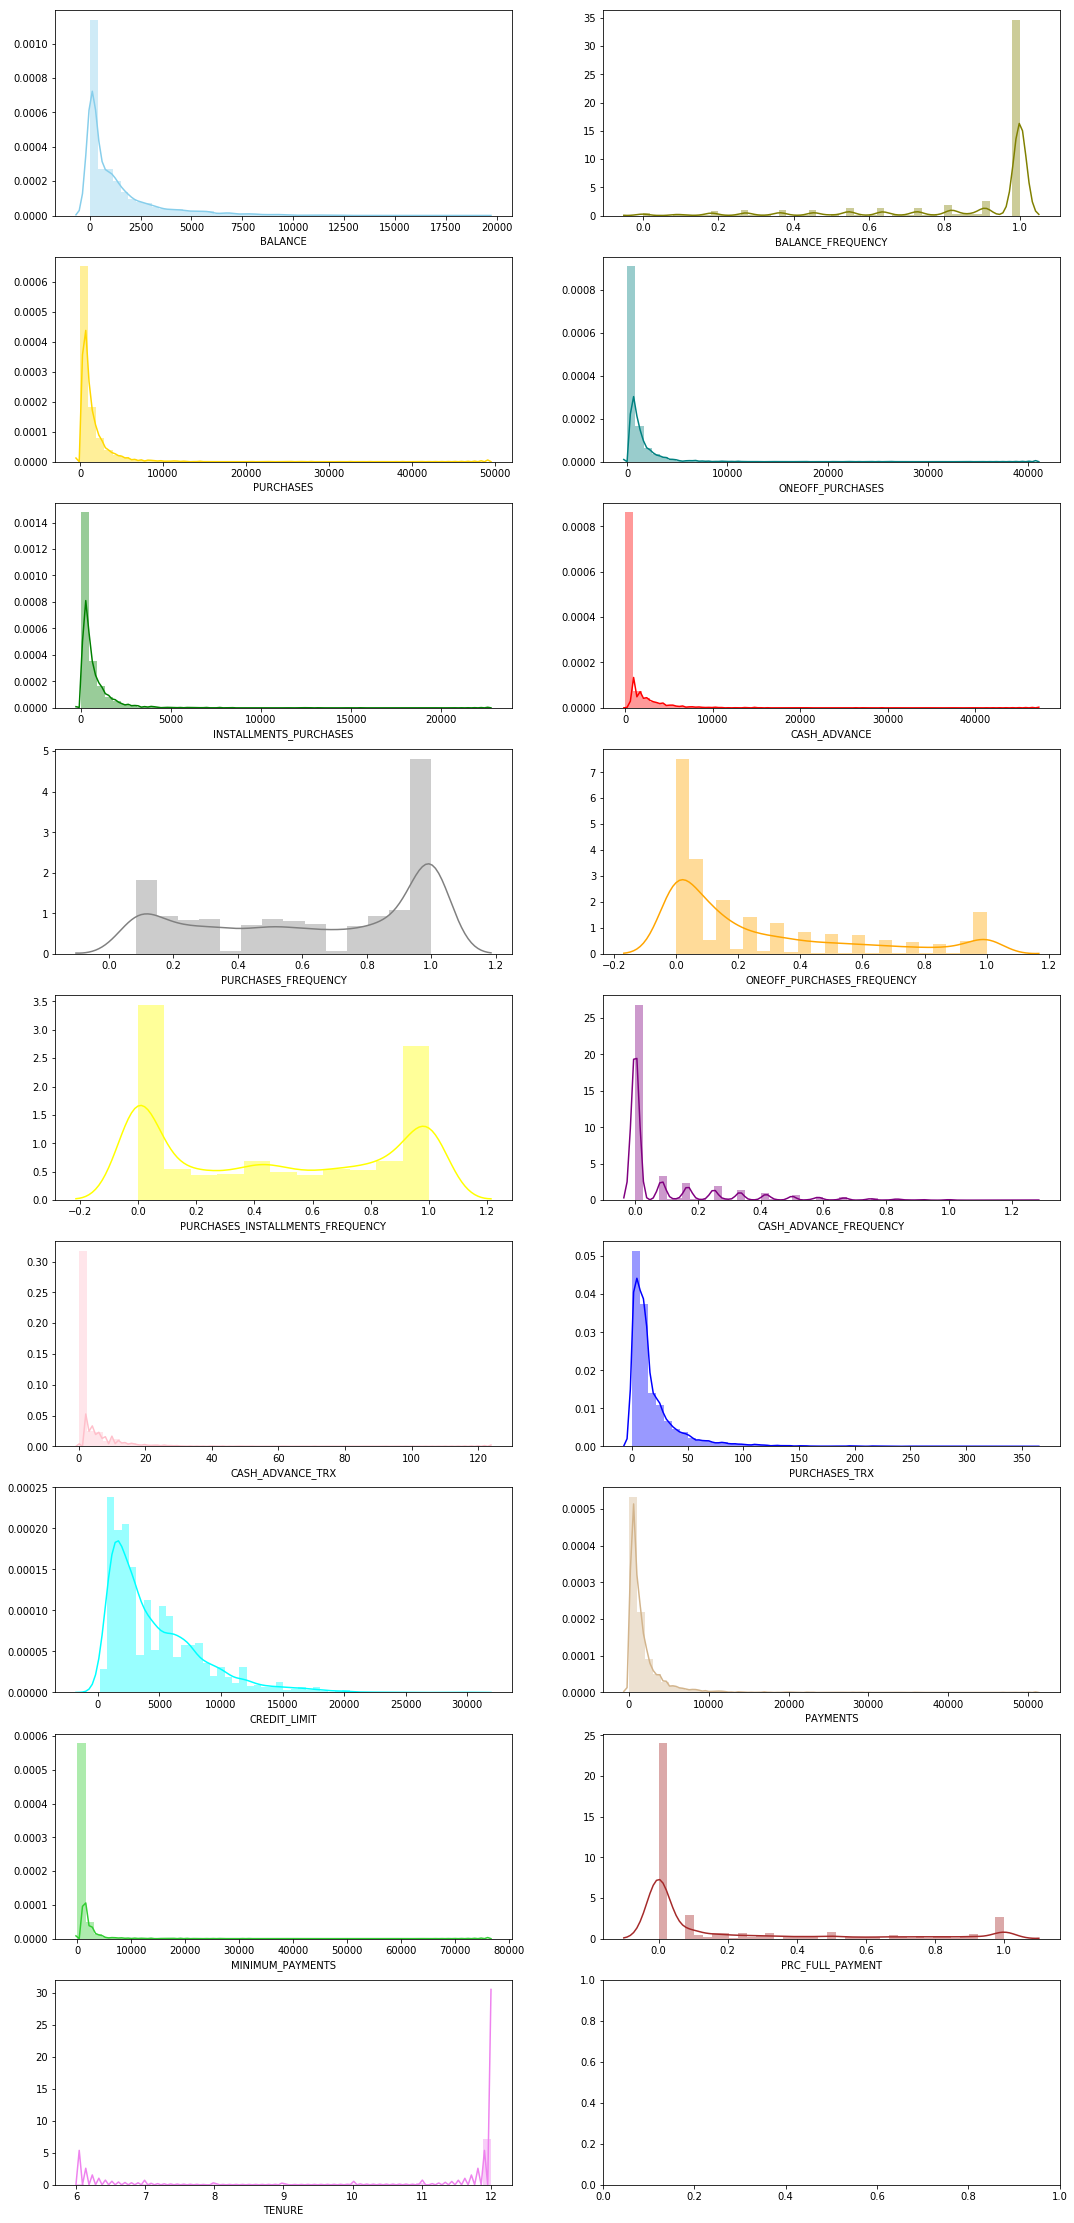

In [171]:
make_plots(data[data["PURCHASES_FREQUENCY"] > 0])

# Illustrate there are fundamental differences
## - customers who make purchases
## - customers who do cash advances
## - customers who do both


In [173]:
len(data[data["PURCHASES"] == 0])

2044

/Users/Jess/anaconda3/envs/insight/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/Jess/anaconda3/envs/insight/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/Jess/anaconda3/envs/insight/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/Users/Jess/anaconda3/envs/insight/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return u

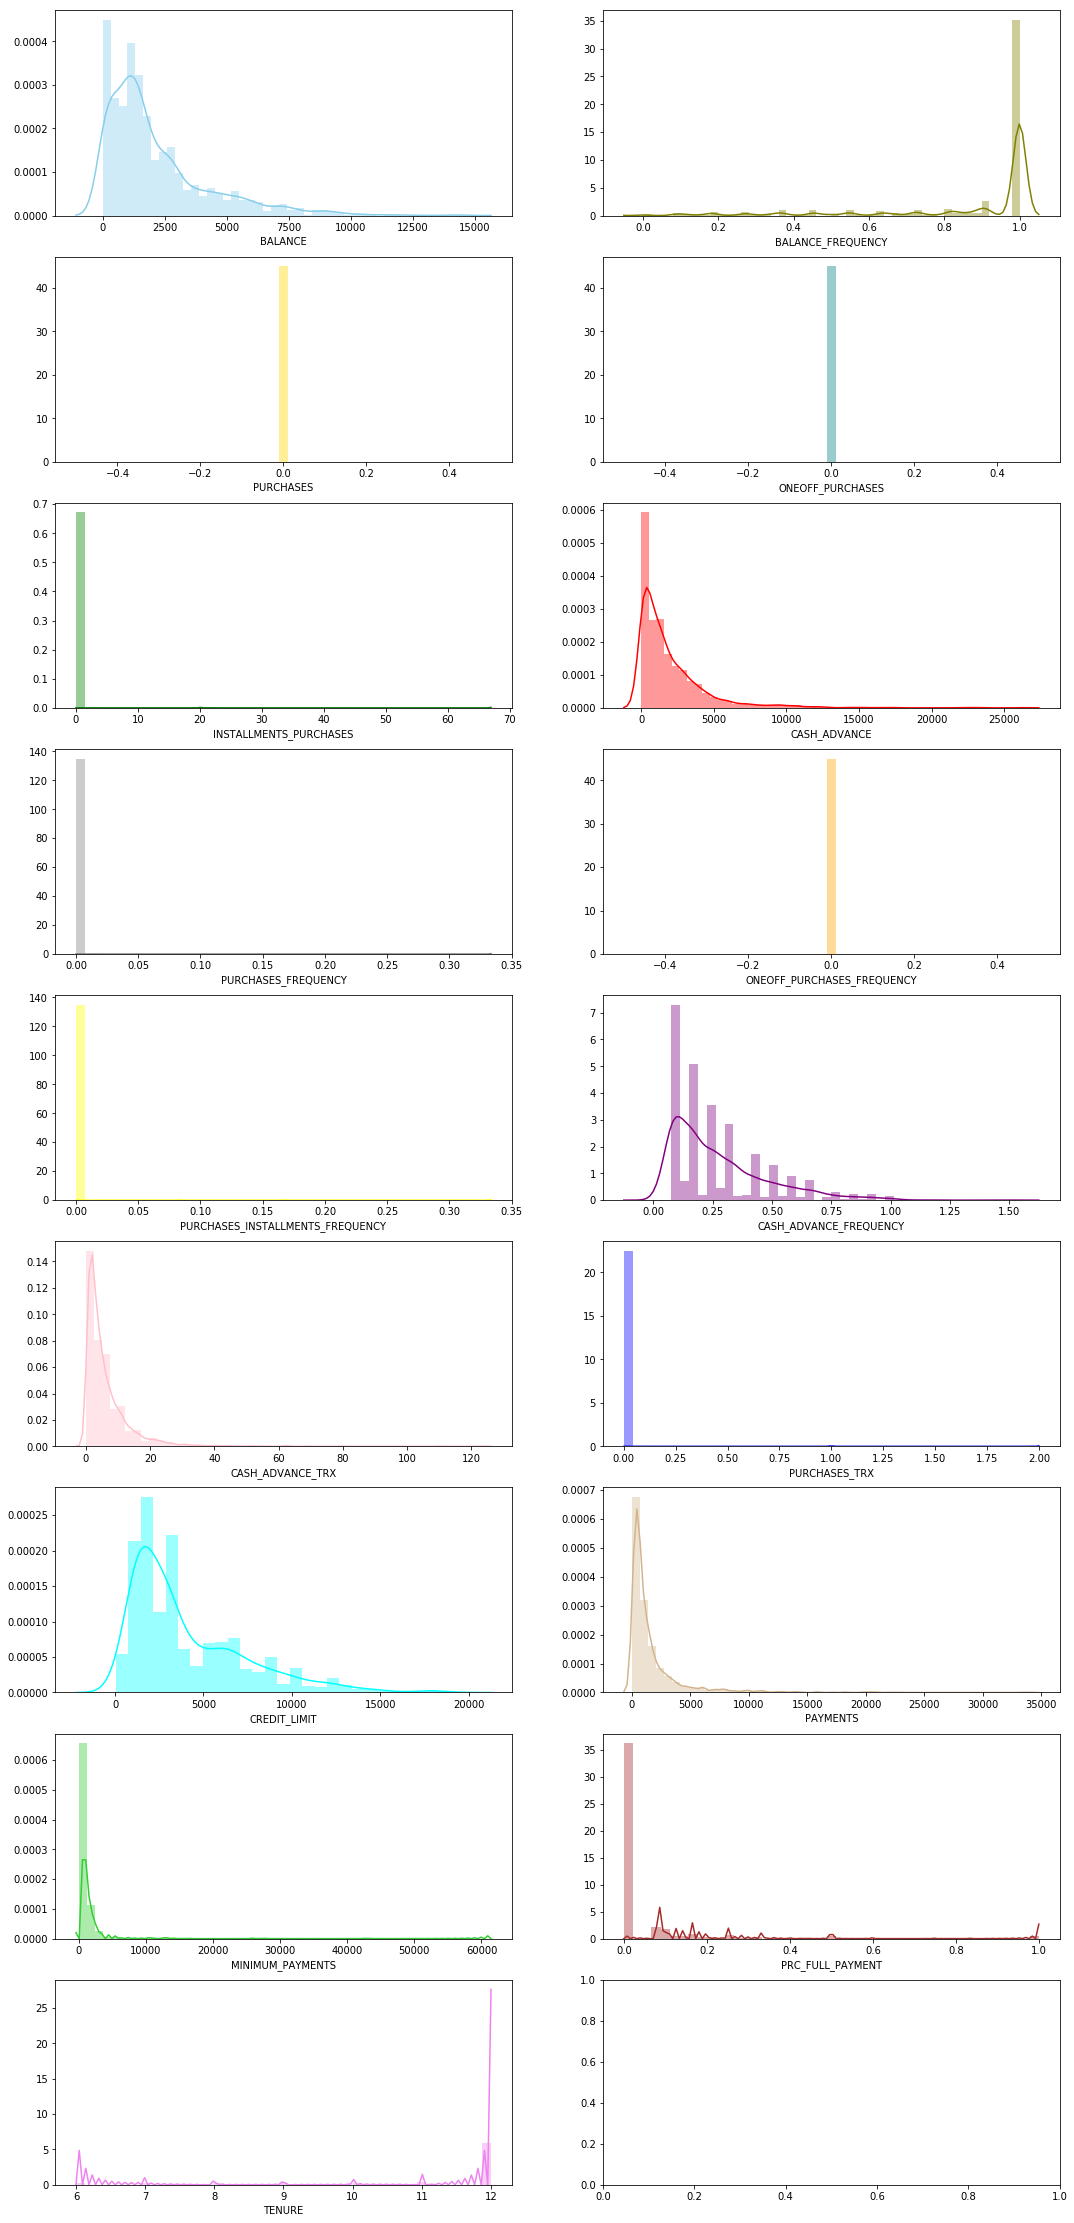

In [172]:
make_plots(data[data["PURCHASES"] == 0])

In [175]:
data['nopurchase'] = data["PURCHASES"]==0

In [191]:
nonadata = data.dropna()
datatoleaveout = ['nopurchase', 'PURCHASES_TRX', 'PURCHASES', 'ONEOFF_PURCHASES', "CUST_ID", 'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY', 'INSTALLMENTS_PURCHASES']


# Almost no customers do neither cash advance nor purchase

In [202]:
print(len(data[data['nopurchase'] & (data['CASH_ADVANCE'] == 0)]),
len(nonadata[nonadata['nopurchase'] & (nonadata['CASH_ADVANCE'] == 0)]))

1 1


In [199]:
len(nonadata[~nonadata['nopurchase'] & (nonadata['CASH_ADVANCE'] >0)])

2239

In [198]:
len(nonadata)

8636

In [196]:
# correlation matrix

nonadata.drop(datatoleaveout, axis=1).corr()

,BALANCE,BALANCE_FREQUENCY,CASH_ADVANCE,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
BALANCE,1.000000,0.310140,0.495586,0.445307,0.382388,0.535518,0.322830,0.398669,-0.333594,0.066987
BALANCE_FREQUENCY,0.310140,1.000000,0.089036,0.181132,0.133265,0.087682,0.039169,0.132519,-0.156961,0.104714
CASH_ADVANCE,0.495586,0.089036,1.000000,0.629030,0.656911,0.304161,0.459342,0.140094,-0.158566,-0.073090
CASH_ADVANCE_FREQUENCY,0.445307,0.181132,0.629030,1.000000,0.799593,0.132841,0.182340,0.098844,-0.260001,-0.140038
CASH_ADVANCE_TRX,0.382388,0.133265,0.656911,0.799593,1.000000,0.150261,0.255921,0.109727,-0.176574,-0.045350
CREDIT_LIMIT,0.535518,0.087682,0.304161,0.132841,0.150261,1.000000,0.426951,0.126671,0.052578,0.136464
PAYMENTS,0.322830,0.039169,0.459342,0.182340,0.255921,0.426951,1.000000,0.126630,0.104668,0.102986
MINIMUM_PAYMENTS,0.398669,0.132519,0.140094,0.098844,0.109727,0.126671,0.126630,1.000000,-0.140404,0.059330
PRC_FULL_PAYMENT,-0.333594,-0.156961,-0.158566,-0.260001,-0.176574,0.052578,0.104668,-0.140404,1.000000,-0.024223
TENURE,0.066987,0.104714,-0.073090,-0.140038,-0.045350,0.136464,0.102986,0.059330,-0.024223,1.000000


In [221]:
# set up binary variables for my groups 

data['nopurchase'] = data["PURCHASES"]==0
data['nocashadvance'] = data["CASH_ADVANCE"]==0
data['purchaseandcash'] = (data["PURCHASES"]> 0) & (data["CASH_ADVANCE"] >0)
data['balance_ish'] = data["PURCHASES"] + data["CASH_ADVANCE"] - data['PAYMENTS']
nonadata = data.dropna()

In [223]:
# This is not a good proxy for Balance. I misunderstand what these variables do.
len(data[data['balance_ish'] == data['BALANCE']])

0

In [217]:
data[['balance_ish']].describe()

,balance_ish
count,8950.000000
mean,248.932094
std,1979.037144
min,-38748.724033
25%,-270.047138
50%,24.916431
75%,736.723559
max,13739.139736


In [218]:
data[['BALANCE']].describe()

,BALANCE
count,8950.000000
mean,1564.474828
std,2081.531879
min,0.000000
25%,128.281915
50%,873.385231
75%,2054.140036
max,19043.138560


# Can I predict "no purchase" with a priori info from a credit report?
# Not really.

In [206]:
model = sm.Logit(nonadata['nopurchase'], nonadata['CREDIT_LIMIT']).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.570155
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             nopurchase   No. Observations:                 8636
Model:                          Logit   Df Residuals:                     8635
Method:                           MLE   Df Model:                            0
Date:                Fri, 19 Oct 2018   Pseudo R-squ.:                -0.06260
Time:                        08:27:39   Log-Likelihood:                -4923.9
converged:                       True   LL-Null:                       -4633.8
                                        LLR p-value:                       nan
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
CREDIT_LIMIT    -0.0002   5.67e-06    -37.962      0.000      -0.000      -0.000
================================================================================
"""

In [222]:
model = sm.Logit(nonadata['nopurchase'], nonadata[['CREDIT_LIMIT', 'TENURE', 'balance_ish']]).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.532073
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             nopurchase   No. Observations:                 8636
Model:                          Logit   Df Residuals:                     8633
Method:                           MLE   Df Model:                            2
Date:                Fri, 19 Oct 2018   Pseudo R-squ.:                0.008370
Time:                        08:38:11   Log-Likelihood:                -4595.0
converged:                       True   LL-Null:                       -4633.8
                                        LLR p-value:                 1.430e-17
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
CREDIT_LIMIT -4.517e-05   7.81e-06     -5.784      0.000   -6.05e-05   -2.99e-05
TENURE          -0.0899      0.004    -25.018      0.000      -0.097      -0.083
balance_ish   2.259e-05   1.46e-05      1.547      0.122   -6.02e-06    5.12e-05
================================================================================
"""

# To make statements for management, need plots and summary stats for each group.


/Users/Jess/anaconda3/envs/insight/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/Jess/anaconda3/envs/insight/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/Jess/anaconda3/envs/insight/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/Users/Jess/anaconda3/envs/insight/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return u

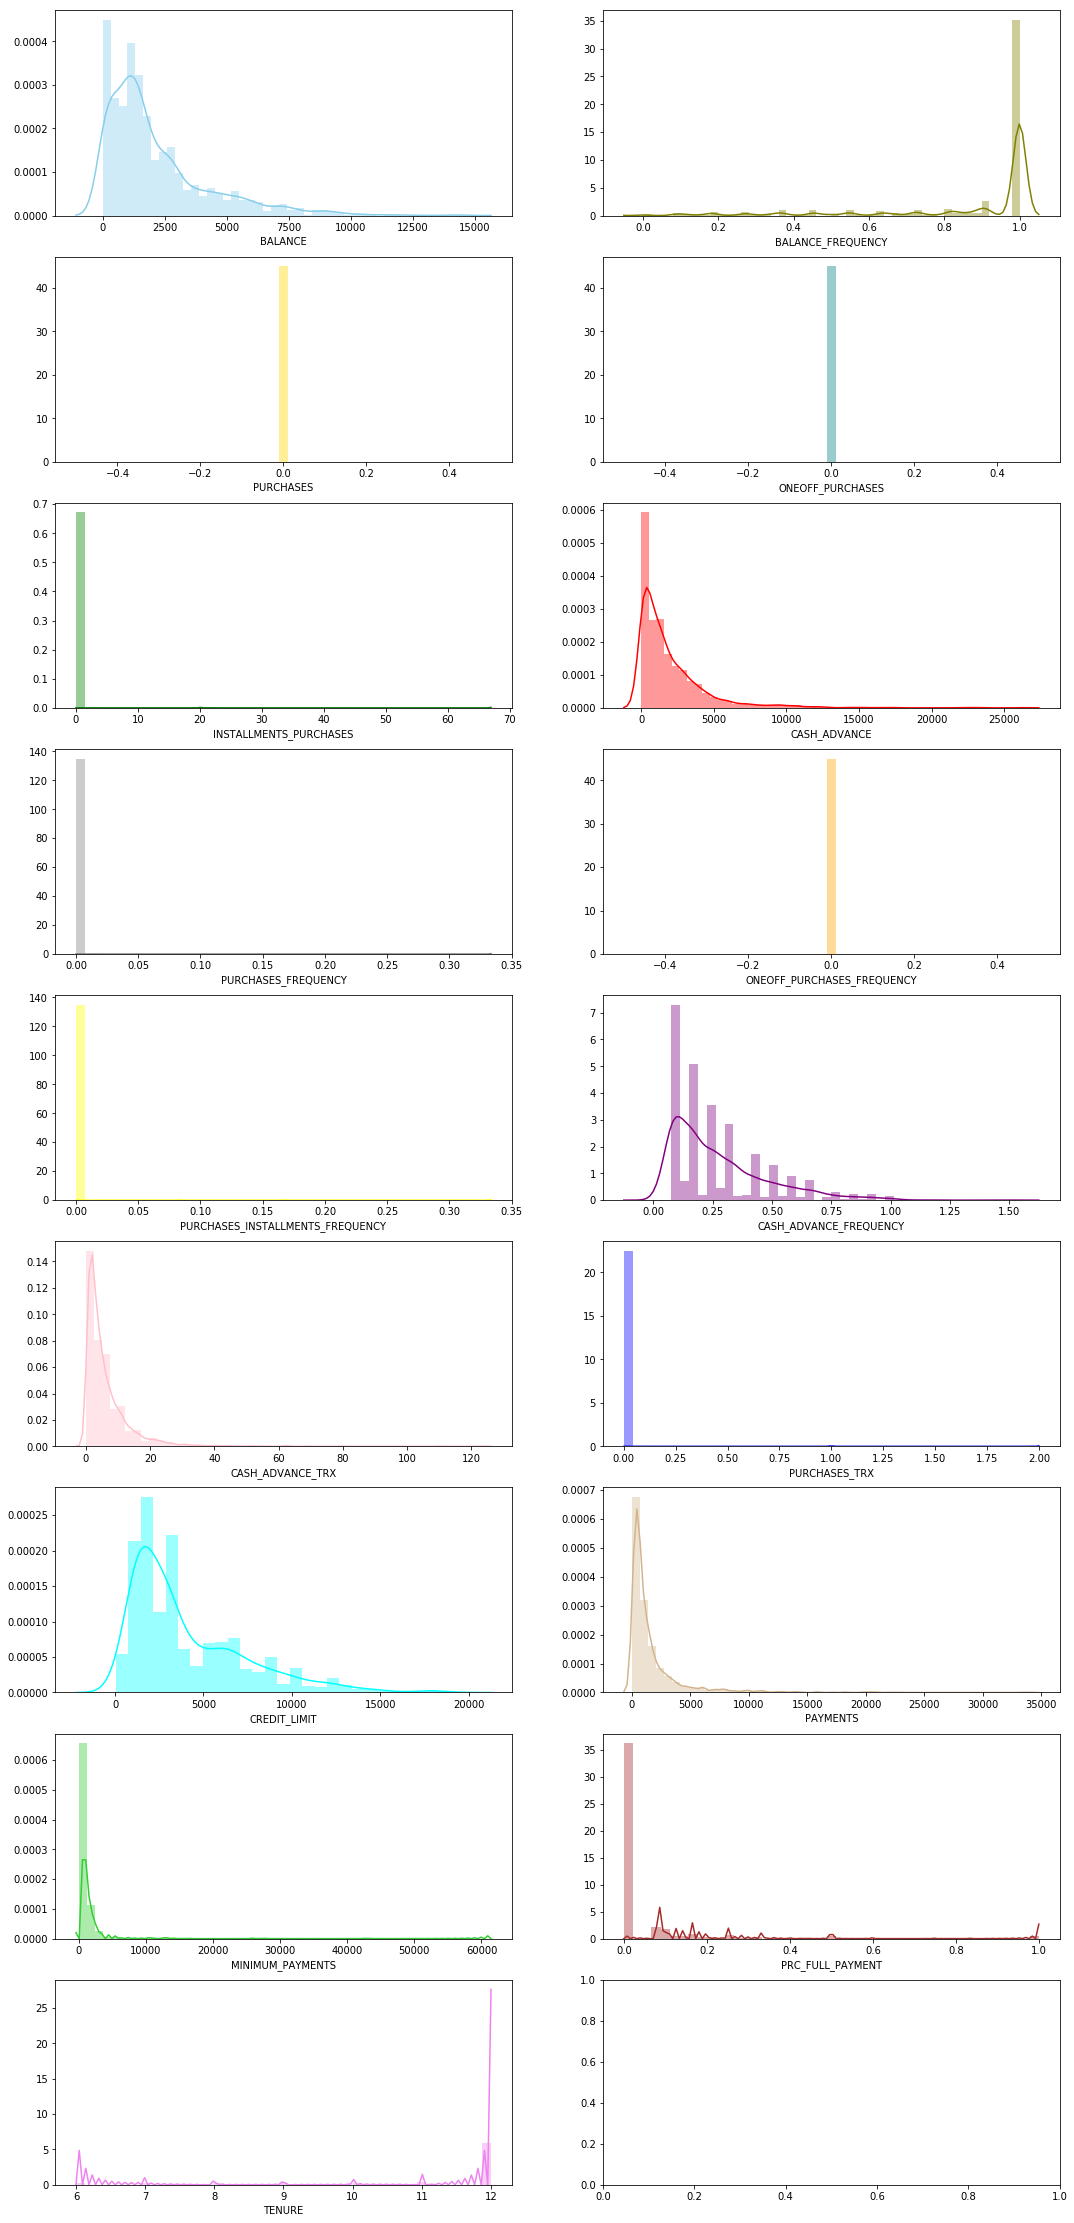

In [224]:
make_plots(data[data["nopurchase"]])

/Users/Jess/anaconda3/envs/insight/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/Jess/anaconda3/envs/insight/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/Jess/anaconda3/envs/insight/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/Users/Jess/anaconda3/envs/insight/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return u

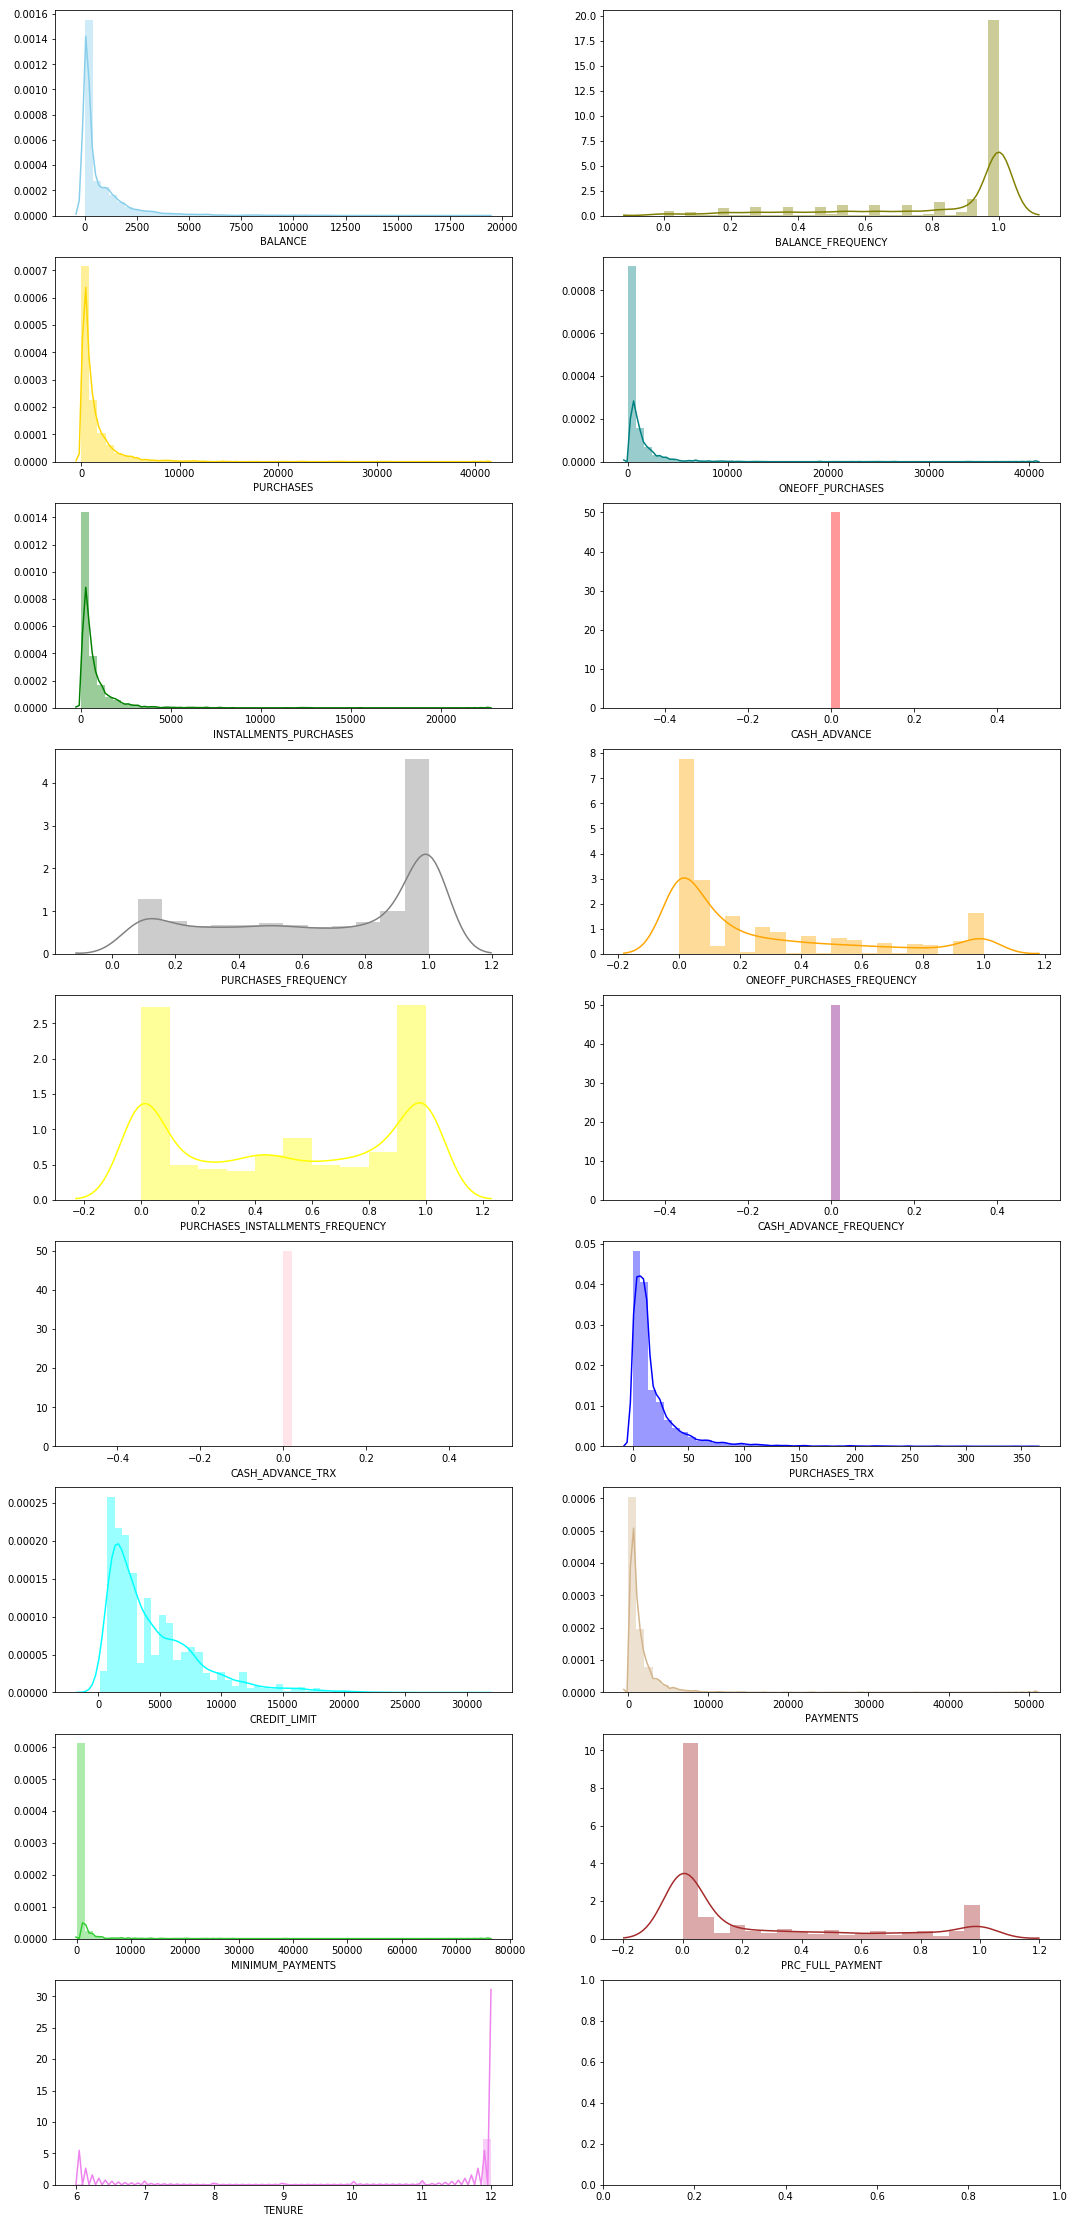

In [225]:
make_plots(data[data["nocashadvance"]])

/Users/Jess/anaconda3/envs/insight/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


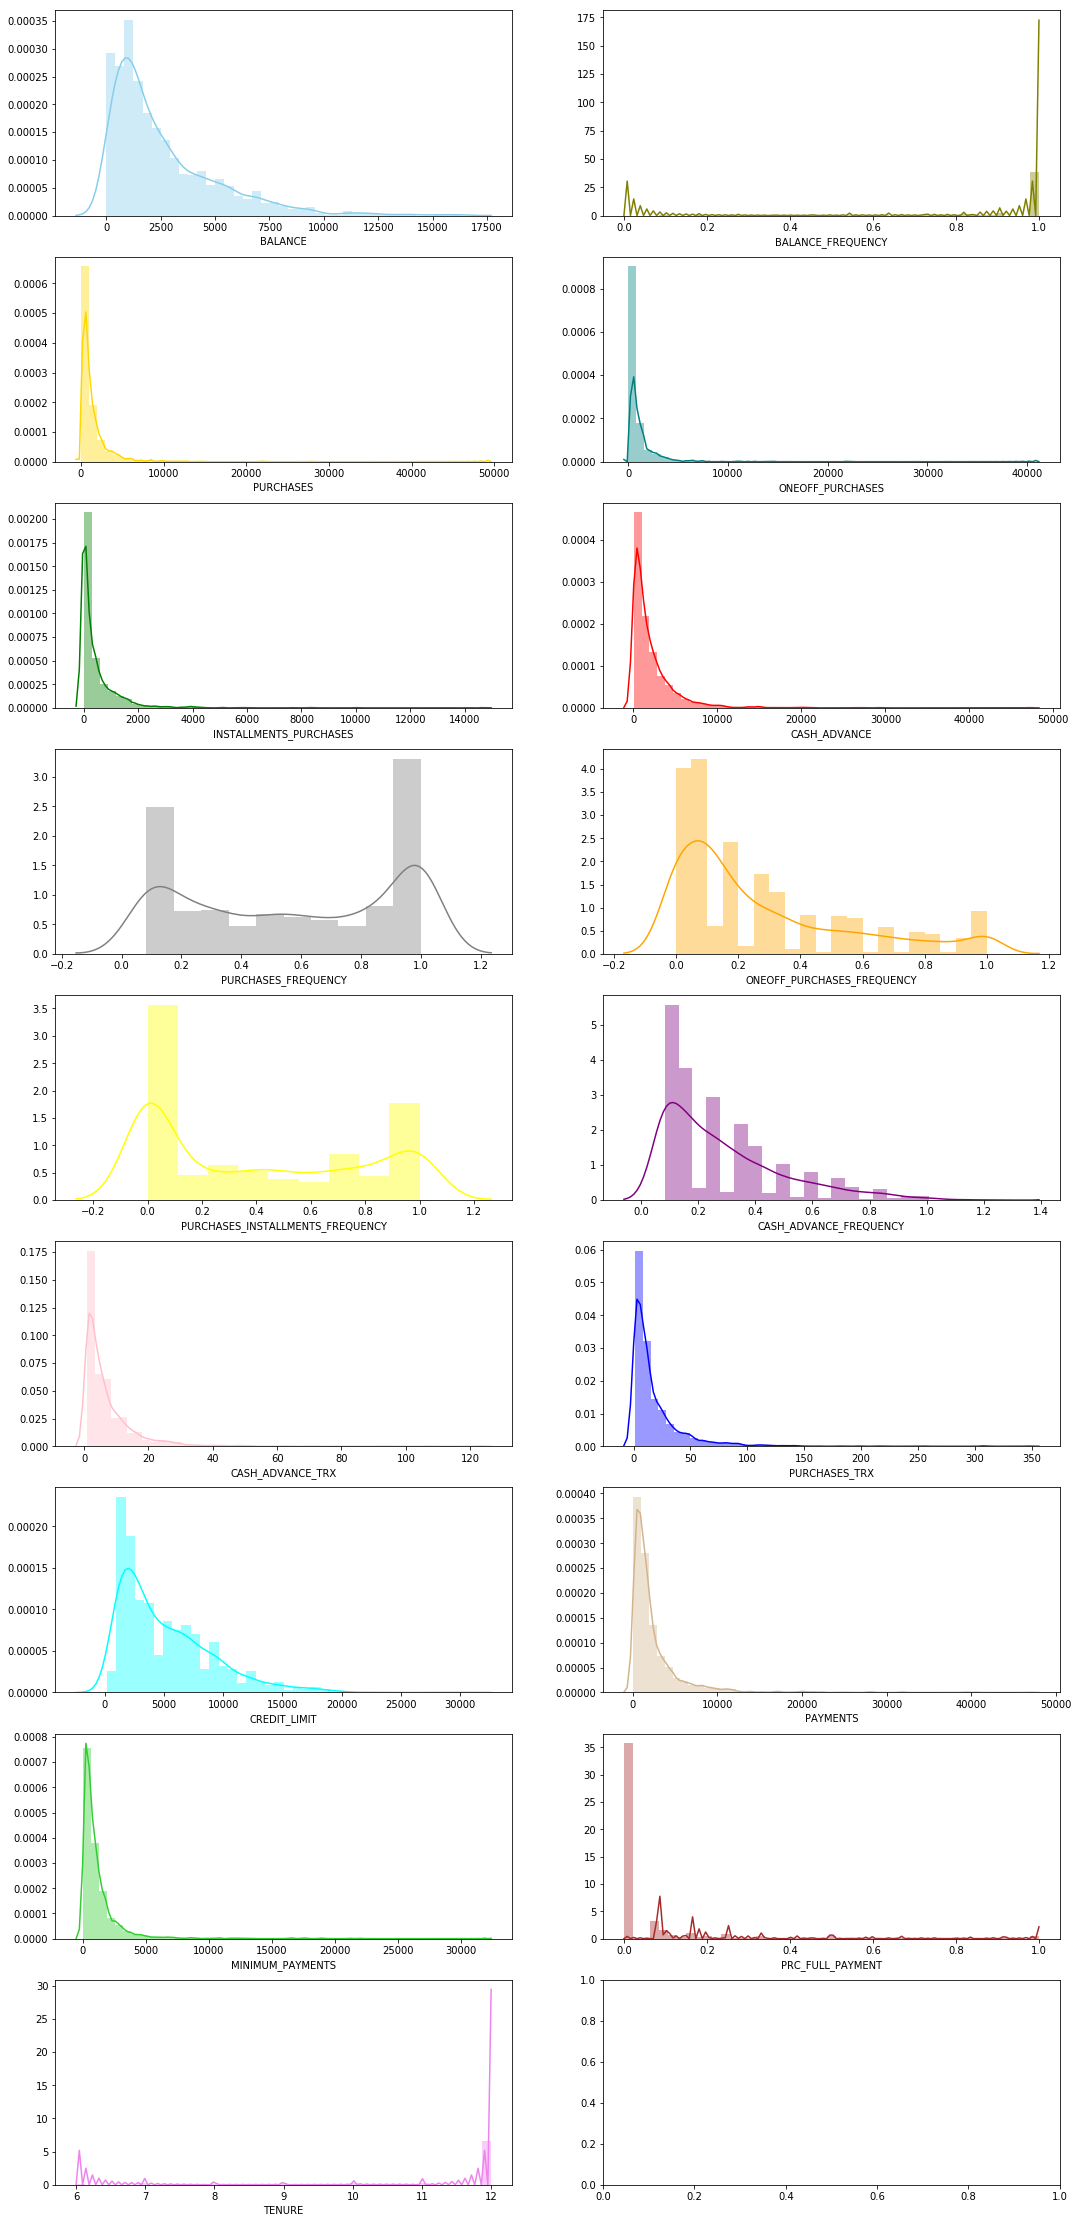

In [226]:
make_plots(data[data["purchaseandcash"]])

In [228]:
data[data["purchaseandcash"]].describe()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,balance_ish
count,2279.000000,2279.000000,2279.000000,2279.000000,2279.000000,2279.000000,2279.000000,2279.000000,2279.000000,2279.000000,2279.000000,2279.000000,2279.000000,2279.000000,2239.000000,2279.000000,2279.000000,2279.000000
mean,2604.934804,0.950885,1202.002133,750.512949,451.770307,2060.511965,0.575861,0.273818,0.402522,0.286251,7.111452,18.273366,5101.463649,2413.652904,1210.326570,0.060713,11.463361,848.861194
std,2504.588050,0.133955,2055.388746,1628.508540,860.771955,2787.661903,0.347483,0.285802,0.388444,0.210097,8.927267,25.672677,3872.552619,3549.958212,1927.523351,0.163883,1.409969,2401.307369
min,0.000000,0.000000,0.010000,0.000000,0.000000,14.222216,0.083333,0.000000,0.000000,0.083333,1.000000,1.000000,200.000000,0.000000,3.197940,0.000000,6.000000,-38748.724033
25%,869.343112,1.000000,233.580000,47.580000,0.000000,403.674068,0.250000,0.083333,0.000000,0.090909,2.000000,4.000000,2000.000000,629.437735,314.573722,0.000000,12.000000,-174.357488
50%,1748.546186,1.000000,586.770000,266.000000,160.000000,1136.000468,0.583333,0.166667,0.333333,0.250000,4.000000,10.000000,4000.000000,1362.230146,673.698985,0.000000,12.000000,618.008188
75%,3625.707480,1.000000,1411.855000,862.420000,558.160000,2695.116021,0.916667,0.416667,0.750000,0.416667,9.000000,23.000000,7250.000000,2722.727114,1387.111044,0.000000,12.000000,1786.562960
max,16304.889250,1.000000,49039.570000,40761.250000,14686.100000,47137.211760,1.000000,1.000000,1.000000,1.250000,123.000000,347.000000,30000.000000,46930.598240,31871.363790,1.000000,12.000000,11982.434117


In [230]:
data[data["nopurchase"]].describe()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,balance_ish
count,2044.000000,2044.000000,2044.0,2044.0,2044.000000,2044.000000,2044.000000,2044.0,2044.000000,2044.000000,2044.000000,2044.000000,2043.000000,2044.000000,1968.000000,2044.000000,2044.000000,2044.000000
mean,2151.202935,0.882500,0.0,0.0,0.042539,1988.742509,0.000163,0.0,0.000285,0.272590,6.296477,0.001957,4029.499103,1653.130103,1006.103729,0.044324,11.318493,335.612406
std,2119.789338,0.232473,0.0,0.0,1.545303,2470.748147,0.007373,0.0,0.008444,0.201176,8.081642,0.054157,3265.518087,2716.349448,2617.181843,0.138202,1.548950,2282.620741
min,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,50.000000,0.000000,0.117036,0.000000,6.000000,-28481.276563
25%,744.593934,0.900000,0.0,0.0,0.000000,377.627175,0.000000,0.0,0.000000,0.090909,2.000000,0.000000,1500.000000,358.885733,266.595169,0.000000,12.000000,-353.904820
50%,1454.882732,1.000000,0.0,0.0,0.000000,1199.455948,0.000000,0.0,0.000000,0.250000,4.000000,0.000000,3000.000000,762.840240,485.990151,0.000000,12.000000,50.912488
75%,2843.531335,1.000000,0.0,0.0,0.000000,2705.281169,0.000000,0.0,0.000000,0.333333,8.000000,0.000000,6000.000000,1725.724856,1007.932823,0.000000,12.000000,1148.791229
max,14581.459140,1.000000,0.0,0.0,66.950000,26194.049540,0.333333,0.0,0.333333,1.500000,123.000000,2.000000,19000.000000,34107.074990,61031.618600,1.000000,12.000000,10050.773262


In [231]:
data[data["nocashadvance"]].describe()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,balance_ish
count,4628.000000,4628.000000,4628.000000,4628.000000,4628.000000,4628.0,4628.000000,4628.000000,4628.000000,4628.0,4628.0,4628.000000,4628.000000,4628.000000,4431.000000,4628.000000,4628.000000,4628.000000
mean,792.725989,0.838737,1348.167761,776.122615,572.468440,0.0,0.664704,0.256691,0.506507,0.0,0.0,19.447710,4400.675412,1433.041782,626.144550,0.247792,11.631806,-84.874020
std,1423.666507,0.267746,2483.289515,1955.028956,1056.171894,0.0,0.334603,0.329210,0.389508,0.0,0.0,27.319695,3637.477506,2535.249052,2434.746210,0.354150,1.180729,1464.080132
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.083333,0.000000,0.000000,0.0,0.0,0.000000,150.000000,0.000000,0.019163,0.000000,6.000000,-32776.483360
25%,42.018337,0.727273,245.847500,0.000000,33.372500,0.0,0.333333,0.000000,0.083333,0.0,0.0,5.000000,1500.000000,316.339174,139.930745,0.000000,12.000000,-260.232346
50%,209.334312,1.000000,600.000000,137.570000,262.370000,0.0,0.750000,0.083333,0.500000,0.0,0.0,12.000000,3000.000000,704.158041,183.429357,0.000000,12.000000,-17.746223
75%,1019.423281,1.000000,1495.775000,850.090000,659.132500,0.0,1.000000,0.416667,0.916667,0.0,0.0,23.000000,6000.000000,1589.863538,411.705082,0.454545,12.000000,180.653218
max,19043.138560,1.000000,41050.400000,40624.060000,22500.000000,0.0,1.000000,1.000000,1.000000,0.0,0.0,358.000000,30000.000000,50721.483360,76406.207520,1.000000,12.000000,13739.139736


# What are the differences in tenure?

In [54]:
unique(data['TENURE'])

array([ 6,  7,  8,  9, 10, 11, 12])

/Users/Jess/anaconda3/envs/insight/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


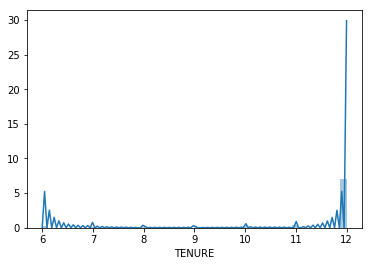

In [55]:
sns.distplot(data['TENURE'])

In [56]:
print(len(data[data['TENURE']==12]), len(data[data['TENURE']==11]), len(data[data['TENURE']==10]))

7584

## May be helpful to run a clustering algorithm on users.

# DB Scan

In [ ]:
# Try different values of epsilon to find ideal number of clusters

In [147]:
# Compute DBSCAN

clustering = DBSCAN(eps=10000, min_samples=2).fit(data.dropna().iloc[:, 1:])

In [148]:
labels = clustering.labels_

In [149]:
clustering 

DBSCAN(algorithm='auto', eps=10000, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=2, n_jobs=1, p=None)

In [150]:
# Number of clusters in labels, ignoring noise if present.

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

In [151]:
print('Estimated number of clusters: %d' % n_clusters_)

Estimated number of clusters: 3


In [133]:
def dbscan_cluster_count(dataframe, epsilon, minsamples):
    # Compute DBSCAN
    clustering = DBSCAN(eps=epsilon, min_samples=2).fit(dataframe.dropna().iloc[:, 1:])
    labels = clustering.labels_
    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    return n_clusters_

In [152]:
# Don't run this, it takes a long time. Figure available by request.
epsilonlist = []
clusterslist = []
for i in range(1,10000, 10):
    epsilonlist.append(i)
    clusterslist.append(dbscan_cluster_count(data, i, 2))

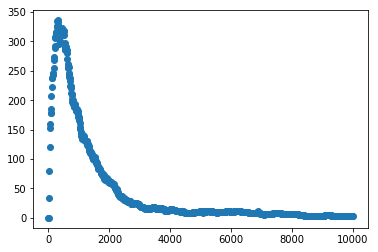

In [153]:
plt.scatter(epsilonlist, clusterslist)

In [158]:
def fit_dbscan(dataframe, epsilon, minsamples):
    clustering = DBSCAN(eps=epsilon, min_samples=minsamples).fit(dataframe)
    labels = clustering.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    print('Estimated number of clusters: %d' % n_clusters_)

In [159]:
fit_dbscan(data.dropna().iloc[:, 1:], 5000, 2)

Estimated number of clusters: 11


# KMEANS

In [ ]:
X = np.matrix(data)

In [43]:
import numpy as np

f1 = data['TENURE'].values
f2 = data['BALANCE'].values
thing = zip(f1,f2)

In [47]:
X= np.matrix(list(zip(f1,f2)))

In [52]:
X

matrix([[  12.      ,   40.900749],
        [  12.      , 3202.467416],
        [  12.      , 2495.148862],
        ...,
        [   6.      ,   23.398673],
        [   6.      ,   13.457564],
        [   6.      ,  372.708075]])

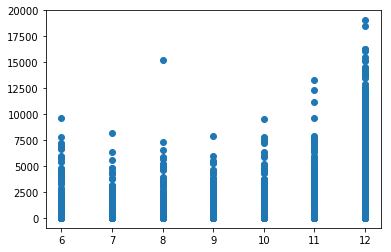

In [53]:
plt.scatter([X[:,0]],[X[:,1]])


In [48]:
# iterate over number of clusters
kmeans = KMeans(n_clusters=2).fit(X)

In [49]:
kmeans.labels_

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)